# 1-1

In [93]:
def exp_kernel(t0, t1, t2, t3, x):
    return t0 * np.exp(-t1 / 2 * (x.reshape(-1, 1) - x.reshape(1, -1)) ** 2) + t2 + t3 * (x.reshape(-1, 1) @ x.reshape(1, -1))

In [43]:
theta_ls = [(0, 0, 0, 1), (1, 4, 0, 0), (1, 4, 0, 5), (1, 32, 5, 5)]

In [44]:
def plot_kernel_value(theata_ls, x):
    fig, ax = plt.subplots(2, 2, figsize=(14, 6))
    ax = ax.flatten()
    empty = np.zeros_like(x).reshape(-1)
    for axi, (t0, t1, t2, t3) in zip(ax, theta_ls):
        #print(axi, t0, t1, t2, t3)
        kernel = exp_kernel(t0, t1, t2, t3, x)
        axi.plot(np.random.multivariate_normal(empty, kernel, size = 5).T)
        axi.set_title(f"(theta: {t0}, {t1}, {t2}, {t3})")
    plt.tight_layout();

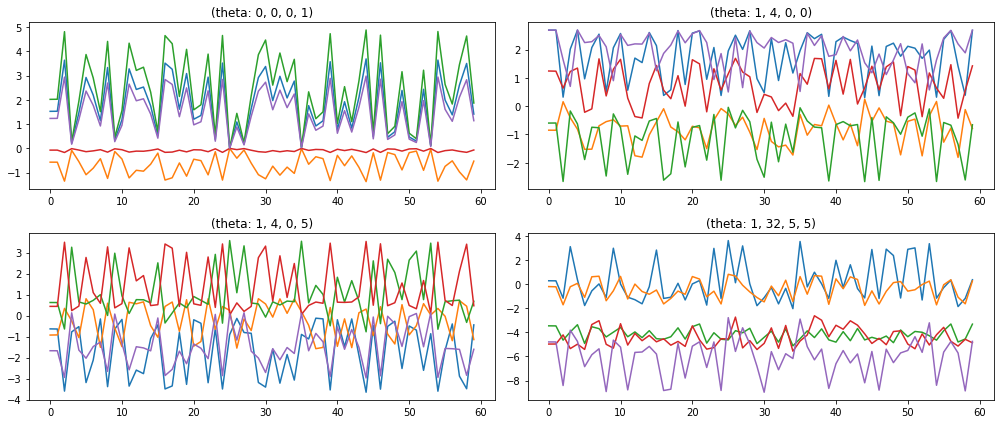

In [45]:
plot_kernel_value(theta_ls, train_x)

In [22]:
from ipywidgets import interact
from sympy import Symbol, Eq, factor

x = Symbol('x')
def factorit(n):
    return Eq(x**n-1, factor(x**n-1))

In [25]:
factorit(15)
interact(factorit, n=(2,40));

interactive(children=(IntSlider(value=21, description='n', max=40, min=2), Output()), _dom_classes=('widget-in…

'print (\'%d iterations for k = %d\' % (i+1, k))\n    print (\'Time cost :\', b-a)\n    table = PrettyTable()\n    table.add_column("k-means mean value", range(k))\n    table.add_column("r", np.round(u[:, 0]*255).astype(\'int\'))\n    table.add_column("g", np.round(u[:, 1]*255).astype(\'int\'))\n    table.add_column("b", np.round(u[:, 2]*255).astype(\'int\'))\n    print (table)'

(172000, 2)


Text(0.5, 1.0, 'GMM maximum likelihood curve')

Text(0.5, 0, 'iterations')

Text(0, 0.5, 'log p(x)')

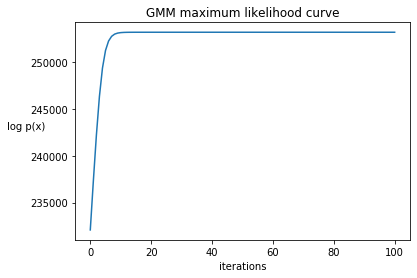

+----------------+-----+-----+-----+
| GMM mean value |  r  |  g  |  b  |
+----------------+-----+-----+-----+
|       0        | 106 | 151 | 192 |
|       1        | 136 | 110 |  14 |
+----------------+-----+-----+-----+


In [3]:
from PIL import Image
import numpy as np
from prettytable import PrettyTable
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from datetime import datetime
import cv2

def log_likelihood(p):
    return np.sum(np.log(np.sum(p, axis=1)))


if __name__ == '__main__':
    img = Image.open('hw3_3.jpeg')
    #img.show(title='origin')
    data = np.asarray(img, dtype='float')/255
    m, n, l = data.shape
    data = np.reshape(data, (-1, l))
    max_iter = 100
    k = 2
    total_length = m * n

    #k-means part
    u = np.random.rand(k, l)
    r = np.full([total_length], k + 1)

    a = datetime.now().replace(microsecond=0)
    for i in range(300):
        dist = np.sum((data[:, None] - u) ** 2, axis=2)
        new_r = np.argmin(dist, axis=1)

        if np.array_equal(r, new_r):
            break
        else:
            r = new_r

        for j in range(k):
            data_k = data[np.where(r == j)]
            if len(data_k) == 0:
                u[j] = np.random.rand(l)
            else:
                u[j] = np.mean(data_k, axis=0)

    b = datetime.now().replace(microsecond=0)
    """print ('%d iterations for k = %d' % (i+1, k))
    print ('Time cost :', b-a)
    table = PrettyTable()
    table.add_column("k-means mean value", range(k))
    table.add_column("r", np.round(u[:, 0]*255).astype('int'))
    table.add_column("g", np.round(u[:, 1]*255).astype('int'))
    table.add_column("b", np.round(u[:, 2]*255).astype('int'))
    print (table)"""

    new_data = np.round(u[r]*255)
    disp = Image.fromarray(new_data.reshape(m, n, l).astype('uint8'))
    disp.show(title='k-means')
    

    #GMM parts
    pi = np.array([len(np.where(r == i)[0])/float(total_length) for i in range(k)])
    cov = np.array([np.cov(data[np.where(r == i)].T) for i in range(k)])
    psb = np.array([multivariate_normal.pdf(data, mean=u[i], cov=cov[i]) for i in range(k)]).T * pi

    likelihood = []
    likelihood.append(log_likelihood(psb))

    
    for i in range(max_iter):
        #E step
        r = psb/np.sum(psb, axis=1)[:, None]
        
        #M step
        N = np.sum(r, axis=0)
        u = np.sum(data[:, None] * r[:, :, None], axis=0)/N[:, None]
        for j in range(k):
            cov[j] = ((data - u[j]) * r[:, j, None]).T.dot(data - u[j])/N[j]
        pi = N/total_length

        #evaluate
        for j in range(k):
            try:
                psb[:, j] = multivariate_normal.pdf(data, mean=u[j], cov=cov[j])*pi[j]
            except np.linalg.linalg.LinAlgError:
                print ('singular error at iteration', i + 1)
                u[j] = np.random.rand(l)
                temp = np.random.rand(l, l)
                cov[j] = temp.dot(temp.T)
                psb[:, j] = multivariate_normal.pdf(data, mean=u[j], cov=cov[j])*pi[j]
    
        likelihood.append(log_likelihood(psb))

    print(r.shape)

    plt.plot(likelihood)
    plt.title('GMM maximum likelihood curve')
    plt.xlabel('iterations')
    plt.ylabel('log p(x)', rotation=0)
    plt.show()

    table2 = PrettyTable()
    table2.add_column("GMM mean value", range(k))
    table2.add_column("r", np.round(u[:, 0]*255).astype('int'))
    table2.add_column("g", np.round(u[:, 1]*255).astype('int'))
    table2.add_column("b", np.round(u[:, 2]*255).astype('int'))
    print (table2)

    r = np.argmax(psb, axis=1)
    new_data = np.round(u[r]*255)
    disp2 = Image.fromarray(new_data.reshape(m, n, l).astype('uint8'))
    disp2.show(title='GMM')
    

In [3]:
def multivariate_normal_(x, d, mean, covariance):
    x_m = x - mean
    return (1. / (np.sqrt((2 * np.pi)**d * np.linalg.det(covariance))) * np.exp(-(np.linalg.solve(covariance, x_m).T.dot(x_m)) / 2))

In [ ]:
pi * np.array([multivariate_normal_(img, 9, mean=u[i], covariance=cov[i]) for i in range(3)]).T

array([0.00108914, 0.01033349, 0.05946514, 0.20755375, 0.43939129,
       0.56418958, 0.43939129, 0.20755375, 0.05946514, 0.01033349])

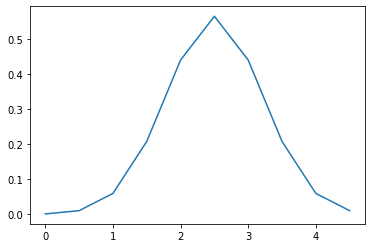

In [8]:
from scipy.stats import multivariate_normal
x = np.linspace(0, 5, 10, endpoint=False)
y = multivariate_normal.pdf(x, mean=2.5, cov=0.5); y

plt.plot(x, y)

In [14]:
np.array([multivariate_normal.pdf(img, mean=u[i], cov=cov[i]) for i in range(3)]).T.shape

(500, 344, 3)